# Imports

In [1]:
import os

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import v2


from dataset import FlowersDataset, Split, generate_splits
from utils.plotting import grid_images, show_results
from utils.image_preprocessor import ResizeStrategy, IrregularImagePreprocessor

/home/chukhran/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/chukhran/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
/home/chukhran/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/visio

# Dataset description

The data collection is based on the data flicr, google images, etc.

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

# Data exploration

Let's visualize random image from each class:

In [2]:
PATH = '/home/chukhran/datasets/flowers'
DATA_PATH = os.path.join(PATH, 'data')
classes = os.listdir(DATA_PATH)

random_images = []
titles = []
images_per_class = 5

bar_plot_stats = {}

for c in classes:
    class_path = os.path.join(DATA_PATH, c)
    bar_plot_stats[c] = len(os.listdir(class_path))
    for i in range(images_per_class):
        random_image = np.random.choice(os.listdir(class_path))
        image = Image.open(os.path.join(class_path, random_image))
        random_images.append(image)
        titles.append(f'{c} {image.size}')


Total images: 4317


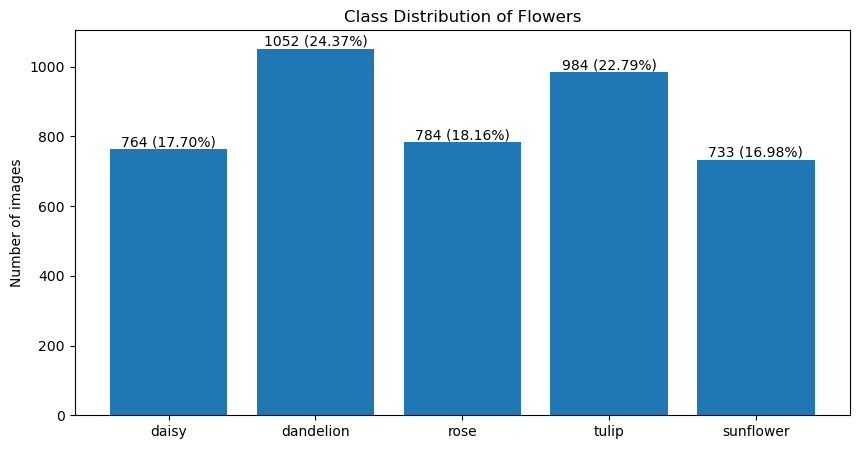

In [3]:
from functools import reduce

total = reduce(lambda x, y: x + y, bar_plot_stats.values())
print(f'Total images: {total}')
plt.figure(figsize=(10, 5))
plt.bar(list(bar_plot_stats.keys()), list(bar_plot_stats.values()))

for i in range(len(bar_plot_stats.values())):
    count = list(bar_plot_stats.values())[i]
    percentage = count / total * 100
    plt.text(i, count, f'{count} ({percentage:.2f}%)', ha='center', va='bottom')

plt.title('Class Distribution of Flowers')
plt.ylabel('Number of images')
plt.show()


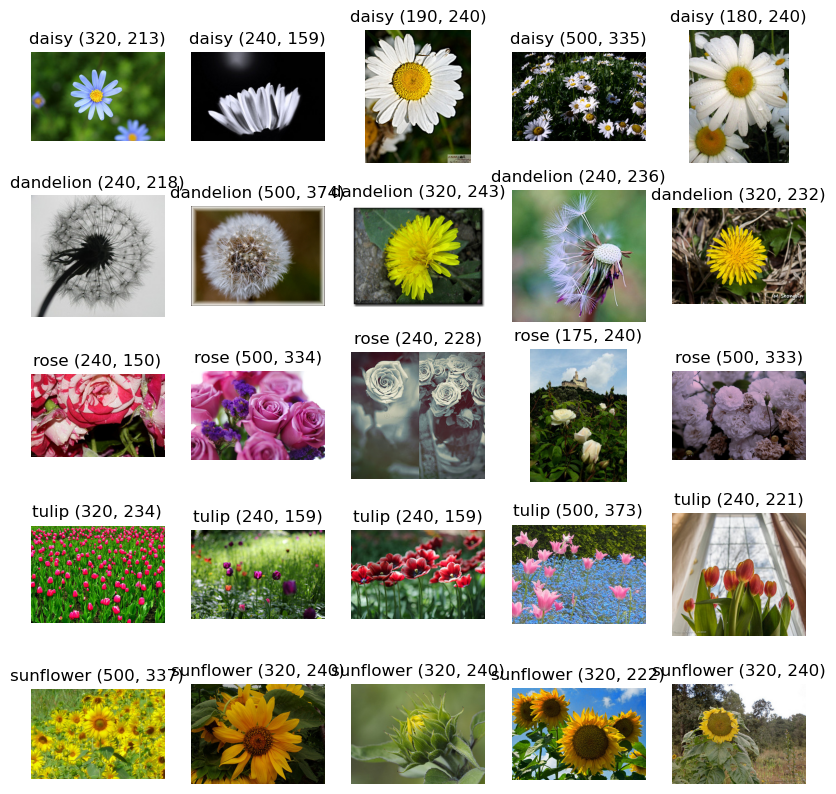

In [4]:
grid_images(images=random_images, titles=titles, rows=len(classes), figsize=(10, 10))

# Handling irregular image sizes
There are few image handling mechanisms available to solve the task:
* simple resize to target size (may distort aspect ratio)
* leave the default size with adding padding around the image
* center crop after resizing
* scale while maintaining aspect ratio

Let's review them all!

## Simple resize

In [5]:
preprocessor = IrregularImagePreprocessor(224, ResizeStrategy.RESIZE)

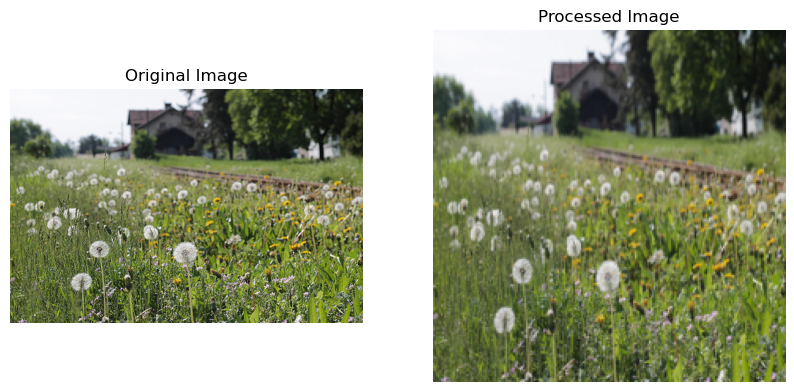

In [6]:
random_class = np.random.choice(classes)
random_sample = np.random.choice(os.listdir(os.path.join(DATA_PATH, random_class)))
image = Image.open(os.path.join(DATA_PATH, random_class, random_sample))

processed_image = preprocessor(image, normalize=False)
grid_images(
    images=[image, processed_image.permute(1, 2, 0)], 
    titles=['Original Image', 'Processed Image'],
    figsize=(10, 5)
    )

### Pros:

- Simple and fast implementation
- Consistent output size
- Works with any batch size
- Memory efficient
- No information loss

### Cons:

- Distorts aspect ratio
- Can deform important features
- May affect model's ability to learn spatial relationships
- Poor choice for objects where shape is important (e.g., faces, text)

## Padding (PAD)

In [7]:
preprocessor = IrregularImagePreprocessor(
    target_size=224,
    resize_strategy=ResizeStrategy.PAD,
    pad_value=0  # Can adjust padding color
)

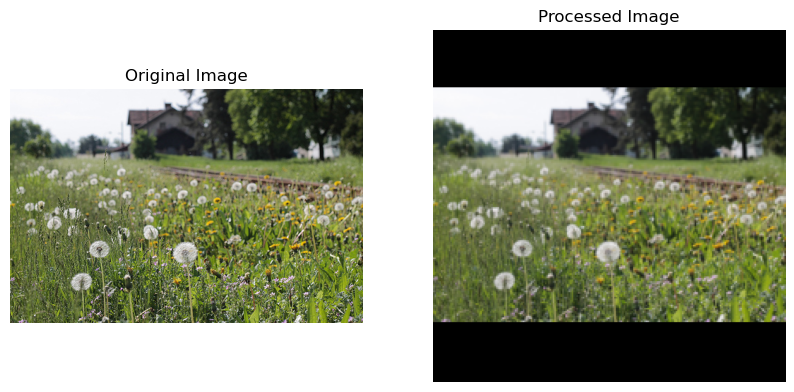

In [8]:
processed_image = preprocessor(image, normalize=False)
grid_images(
    images=[image, processed_image.permute(1, 2, 0)], 
    titles=['Original Image', 'Processed Image'],
    figsize=(10, 5)
    )

### Pros:

- Preserves aspect ratio
- No information loss
- Maintains original image proportions
- Good for object detection/segmentation

### Cons:

- Introduces artificial borders
- Wastes computational resources on padded areas
- May affect model's attention mechanism
- Increased memory usage due to padding

## Center Crop (CROP)

In [9]:
preprocessor = IrregularImagePreprocessor(
    target_size=224,
    resize_strategy=ResizeStrategy.CROP
)

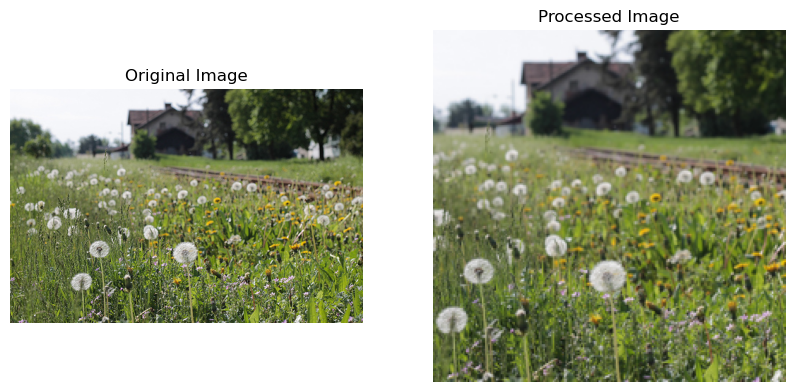

In [10]:
processed_image = preprocessor(image, normalize=False)
grid_images(
    images=[image, processed_image.permute(1, 2, 0)], 
    titles=['Original Image', 'Processed Image'],
    figsize=(10, 5)
    )

### Pros:

- Clean, consistent output size
- No distortion of visible content
- Memory efficient
- Good for classification when objects are centered

### Cons:

- Loses information from image edges
- May cut off important features
- Not suitable for object detection
- Assumes important content is centered

## Scale

In [11]:
preprocessor = IrregularImagePreprocessor(
    target_size=224,
    resize_strategy=ResizeStrategy.SCALE,
    keep_aspect_ratio=True
)

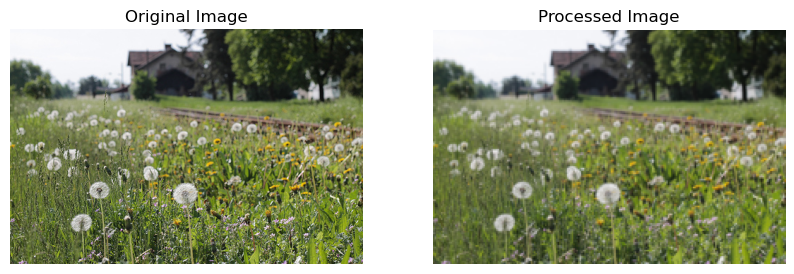

In [12]:
processed_image = preprocessor(image, normalize=False)
grid_images(
    images=[image, processed_image.permute(1, 2, 0)], 
    titles=['Original Image', 'Processed Image'],
    figsize=(10, 5)
    )

### Pros:

- Preserves aspect ratio
- No distortion
- No information loss
- Good for maintaining spatial relationships

### Cons:

- Variable output sizes if keep_aspect_ratio=True
- May need custom collate function for batching
- Can be slower due to variable sizes
- More complex implementation

# Splitting the data

In [5]:
splits = {
    Split.TRAIN.value: 0.8, 
    Split.VALIDATION.value: 0.1, 
    Split.TEST.value: 0.1
}

dataset_splits = generate_splits(DATA_PATH, splits)
splits_path = os.path.join(PATH, 'splits')
os.makedirs(splits_path, exist_ok=True)
for split in dataset_splits:
    with open(os.path.join(splits_path, f'{split}.list'), 'w') as f:
        f.write('\n'.join(dataset_splits[split]))

In [6]:
for split_name in dataset_splits.keys():
    print(f'{split_name}:')
    print("\n".join(dataset_splits[split_name][:5]))

train:
daisy/13901930939_a7733c03f0_n.jpg
daisy/14600779226_7bbc288d40_m.jpg
daisy/34508227161_a9ff840f71_n.jpg
daisy/3704305945_a80e60e2f6_m.jpg
daisy/33849854704_d2a2415e4d_n.jpg
validation:
daisy/14264136211_9531fbc144.jpg
daisy/4407065098_ef25f1ccac_n.jpg
daisy/9204730092_a7f2182347.jpg
daisy/10140303196_b88d3d6cec.jpg
daisy/3975010332_3209f9f447_m.jpg
test:
daisy/8671824531_64b816949e_m.jpg
daisy/3504430338_77d6a7fab4_n.jpg
daisy/5981645737_29eceac291_m.jpg
daisy/8619103877_d8c82c5f34_n.jpg
daisy/16020253176_60f2a6a5ca_n.jpg


# Setting up training
## Defining data loading

In [7]:
transform = v2.Compose([
    v2.Resize((128, 128)),
    v2.RandomVerticalFlip(),
    v2.RandomHorizontalFlip(),
    v2.ToTensor(),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_ds = FlowersDataset(path=PATH, split=Split.TRAIN, transform=transform)
val_ds = FlowersDataset(path=PATH, split=Split.VALIDATION, transform=transform)
test_ds = FlowersDataset(path=PATH, split=Split.TEST, transform=transform)

TRAIN_BATCH_SIZE = 32
VAL_BATCH_SIZE = 8

train_loader = DataLoader(train_ds, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=VAL_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=VAL_BATCH_SIZE, shuffle=False)


/home/chukhran/miniconda3/envs/ml/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [8]:
from core import train, TrainParams, StepStatistics

In [9]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

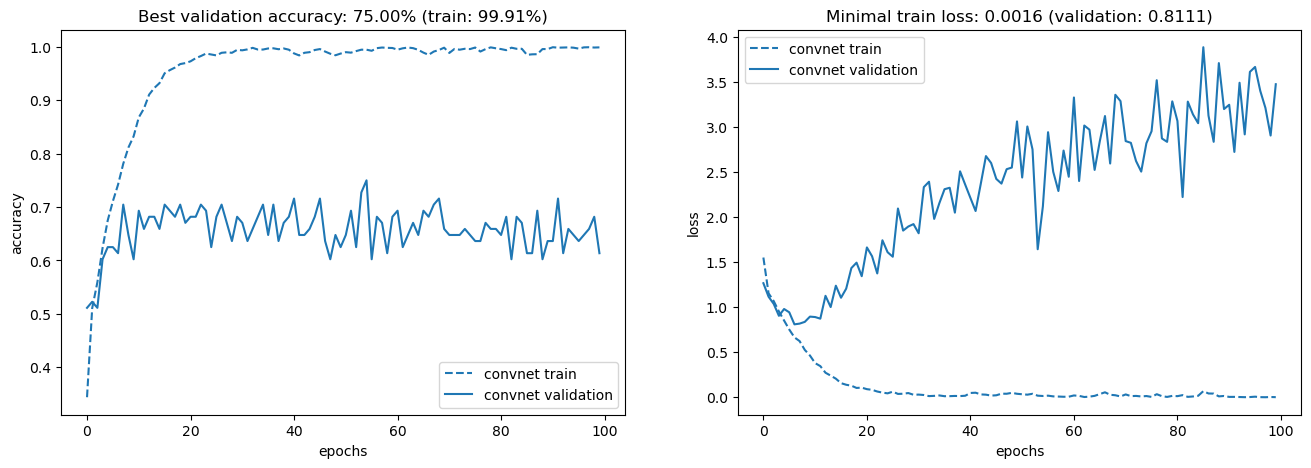

In [10]:
convnet = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 30 * 30, 128),
    nn.ReLU(),
    nn.Linear(128, len(classes)),
)

params = TrainParams(
    model=convnet,
    loaders={'train': train_loader, 'validation': val_loader},
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(convnet.parameters(), lr=0.001),   
    num_epochs=100,
    device=DEVICE,
)

convnet_logs = train(params)
show_results(convnet=convnet_logs)

This model shows clear signs of overfitting. While the training accuracy reaches nearly 100% and training loss approaches zero, the validation accuracy plateaus around 65-70% and validation loss steadily increases. The large gap between training and validation performance indicates the model is memorizing the training data rather than learning generalizable features.

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

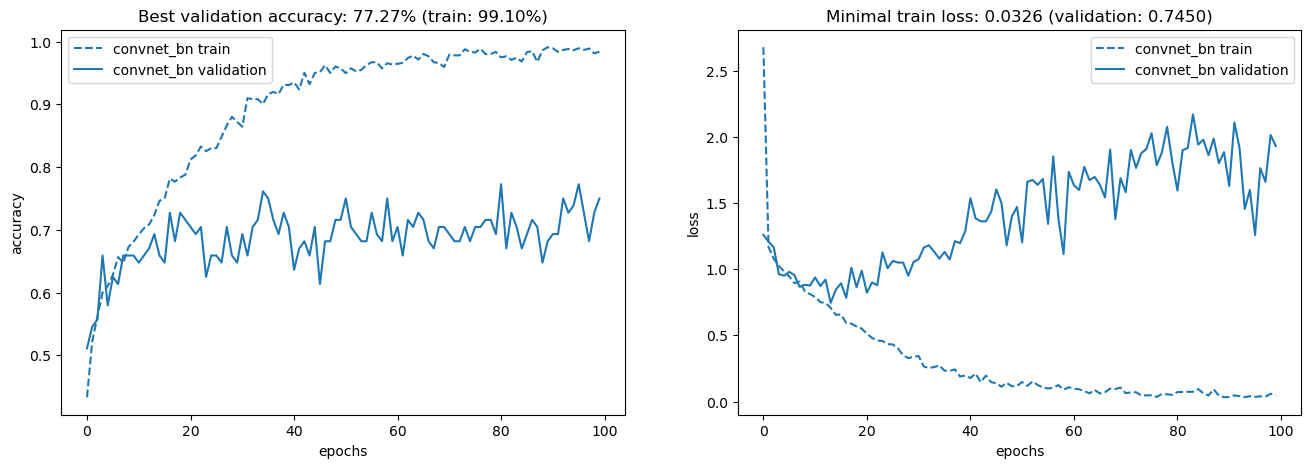

In [11]:
convnet_bn = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 30 * 30, 128),
    nn.ReLU(),
    nn.Linear(128, len(classes))
)
bn_params = TrainParams(
    model=convnet_bn,
    loaders={'train': train_loader, 'validation': val_loader},
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(convnet_bn.parameters(), lr=0.001),
    num_epochs=100,
    device=DEVICE
)

convnet_bn_logs = train(bn_params)
show_results(convnet_bn=convnet_bn_logs)

Adding batch normalization improved the model's performance slightly. The validation accuracy increased by ~2% compared to the basic ConvNet. While still showing signs of overfitting, the gap between training and validation performance is somewhat smaller. The validation loss is also lower than the basic model, suggesting better generalization.

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

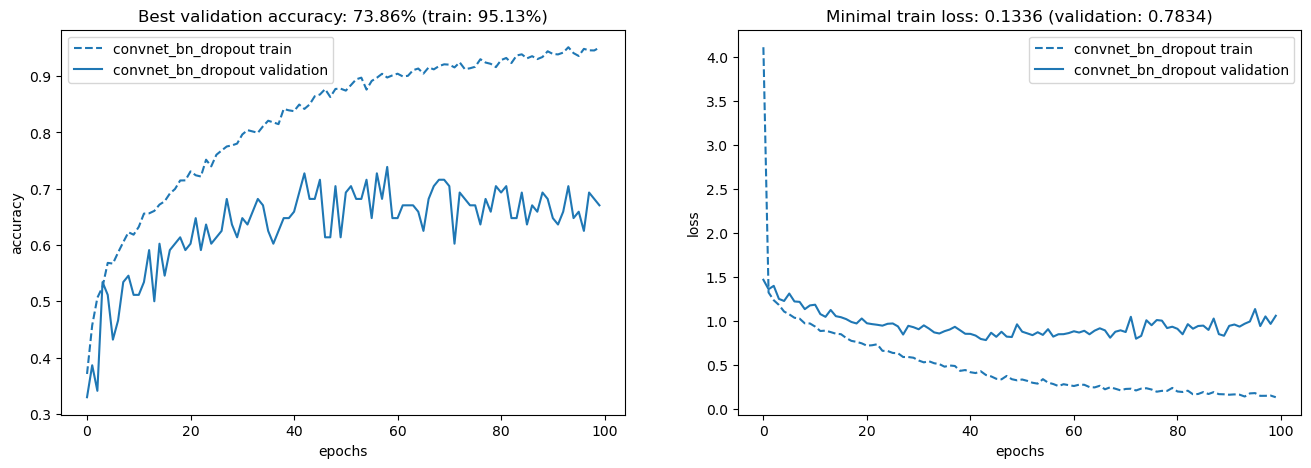

In [12]:
convnet_bn_dropout = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 30 * 30, 128),
    nn.ReLU(),
    nn.Linear(128, len(classes))
)
bn_dropout_params = TrainParams(
    model=convnet_bn_dropout,
    loaders={'train': train_loader, 'validation': val_loader},
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(convnet_bn_dropout.parameters(), lr=0.001),
    num_epochs=100,
    device=DEVICE
)

convnet_bn_dropout_logs = train(bn_dropout_params)
show_results(convnet_bn_dropout=convnet_bn_dropout_logs)

 Adding dropout reduced overfitting, as evidenced by the smaller gap between training and validation accuracy. The training accuracy dropped to 95.13% (from 99%+), indicating that the regularization is working. However, the validation accuracy slightly decreased, suggesting that the dropout rate (0.5) might be too aggressive for this particular task.

Epochs:   0%|          | 0/100 [00:00<?, ?it/s]

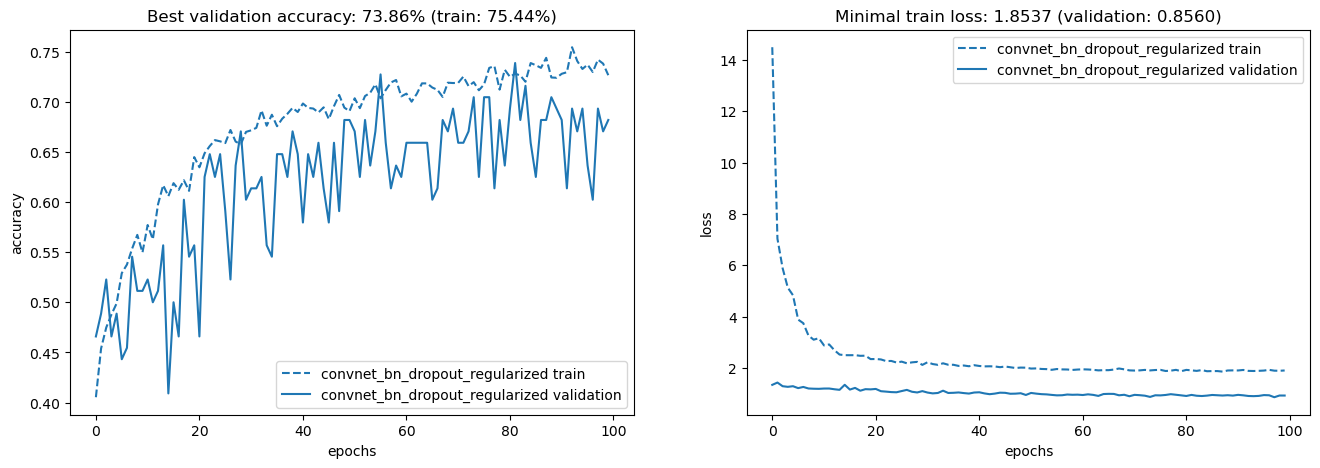

In [15]:
from core import l1_regularization, l2_regularization

convnet_bn_dropout_regularized = nn.Sequential(
    nn.Conv2d(3, 32, 3),
    nn.BatchNorm2d(32),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.MaxPool2d(2),
    nn.Conv2d(32, 64, 3),
    nn.BatchNorm2d(64),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.MaxPool2d(2),
    nn.Flatten(),
    nn.Linear(64 * 30 * 30, 128),
    nn.ReLU(),
    nn.Linear(128, len(classes))
)
bn_dropout_params = TrainParams(
    model=convnet_bn_dropout_regularized,
    loaders={'train': train_loader, 'validation': val_loader},
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(convnet_bn_dropout_regularized.parameters(), lr=0.001),
    num_epochs=100,
    device=DEVICE,
    regularization={l1_regularization: 0.001, l2_regularization: 0.001}
)

convnet_bn_dropout_regularized_logs = train(bn_dropout_params)

show_results(convnet_bn_dropout_regularized=convnet_bn_dropout_regularized_logs)

This most heavily regularized model shows the least overfitting, with the smallest gap between training and validation performance. However, it also has the lowest overall performance. The combination of dropout and L1/L2 regularization (both at 0.001) might be too strong, causing underfitting. The model struggles to learn effectively, as shown by the relatively low training accuracy of 76.01%.

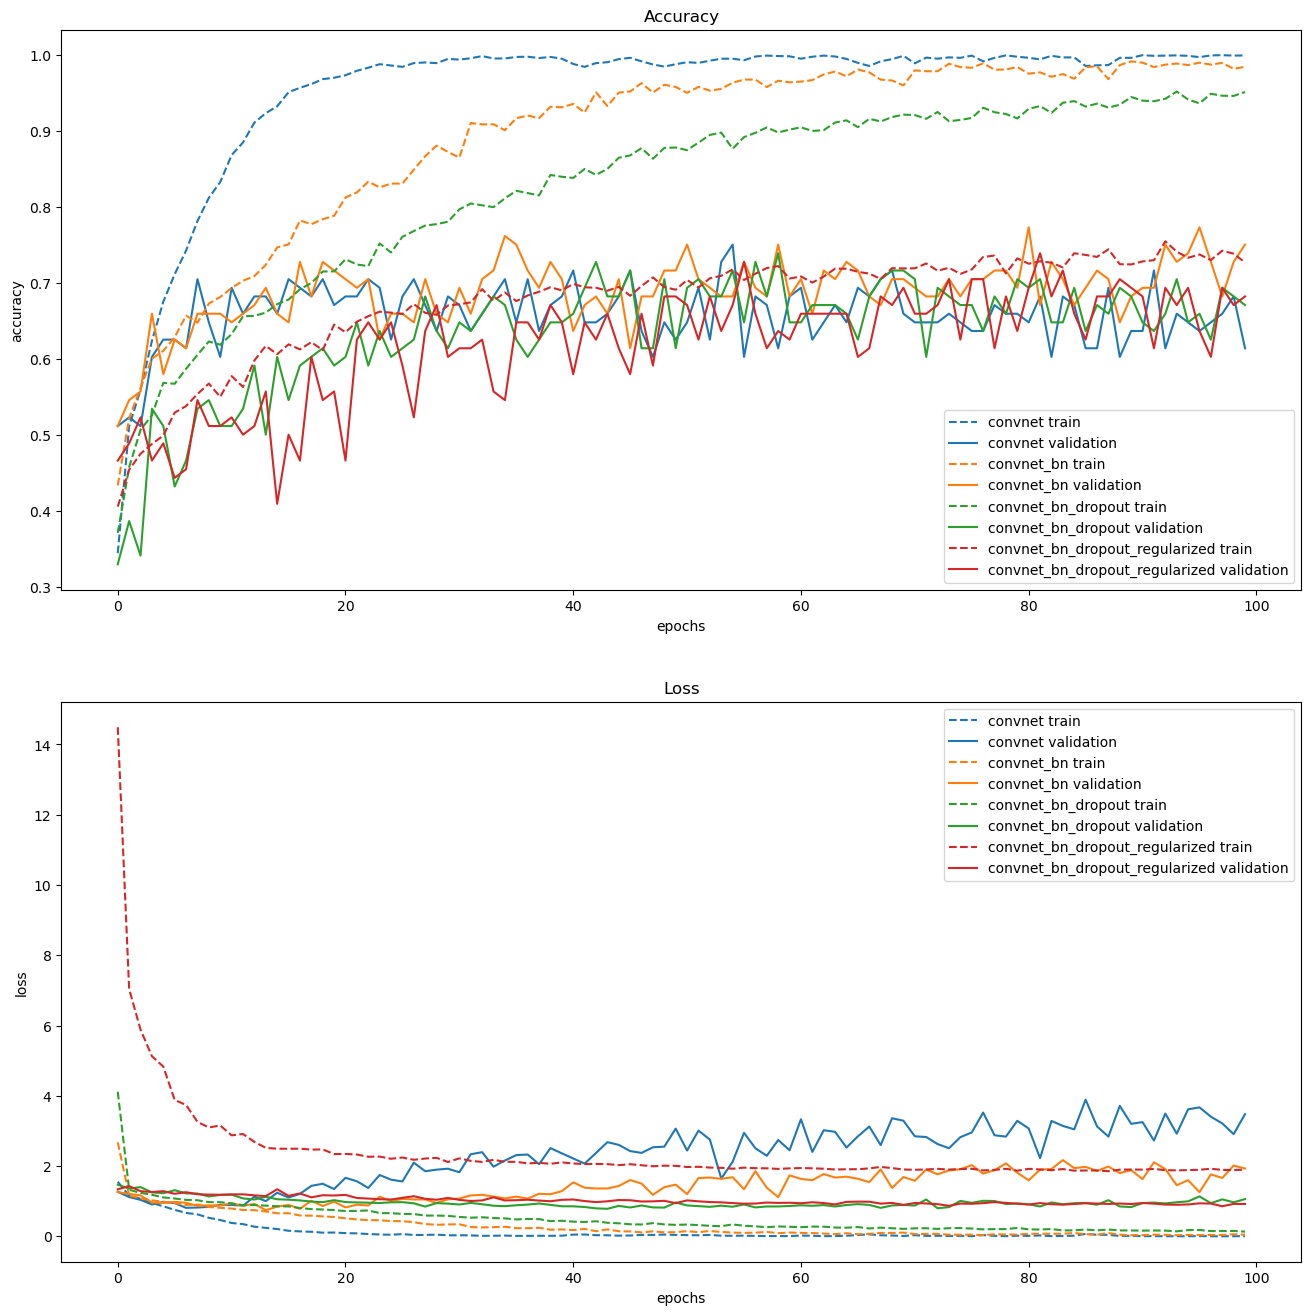

In [18]:
show_results(
    convnet=convnet_logs,
    convnet_bn=convnet_bn_logs,
    convnet_bn_dropout=convnet_bn_dropout_logs,
    convnet_bn_dropout_regularized=convnet_bn_dropout_regularized_logs,
    orientation='vertical',
    
)

In [22]:
random_class = np.random.choice(classes)
random_image = np.random.choice(os.listdir(os.path.join(DATA_PATH, random_class)))
image = Image.open(os.path.join(DATA_PATH, random_class, random_image))
normalized_image = transform(image).permute(1, 2, 0).numpy()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


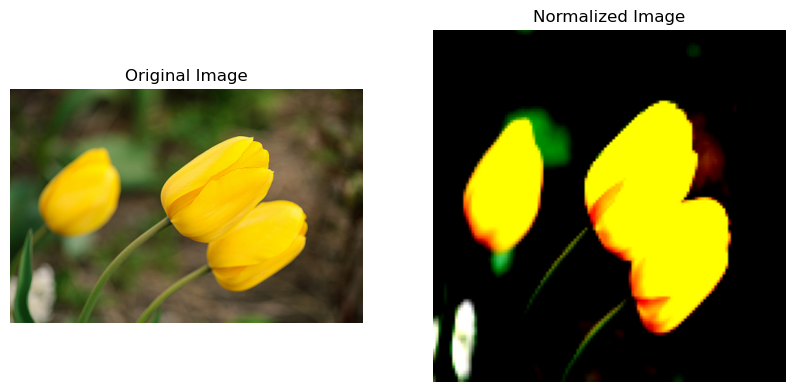

In [23]:
grid_images([image, normalized_image], ['Original Image', 'Normalized Image'], figsize=(10, 5))